---
title: 'Lab02: Portugese Bank Marketing Data'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Will Jones, Nick Sager"
date: October 16, 2023
jupyter: python3
---

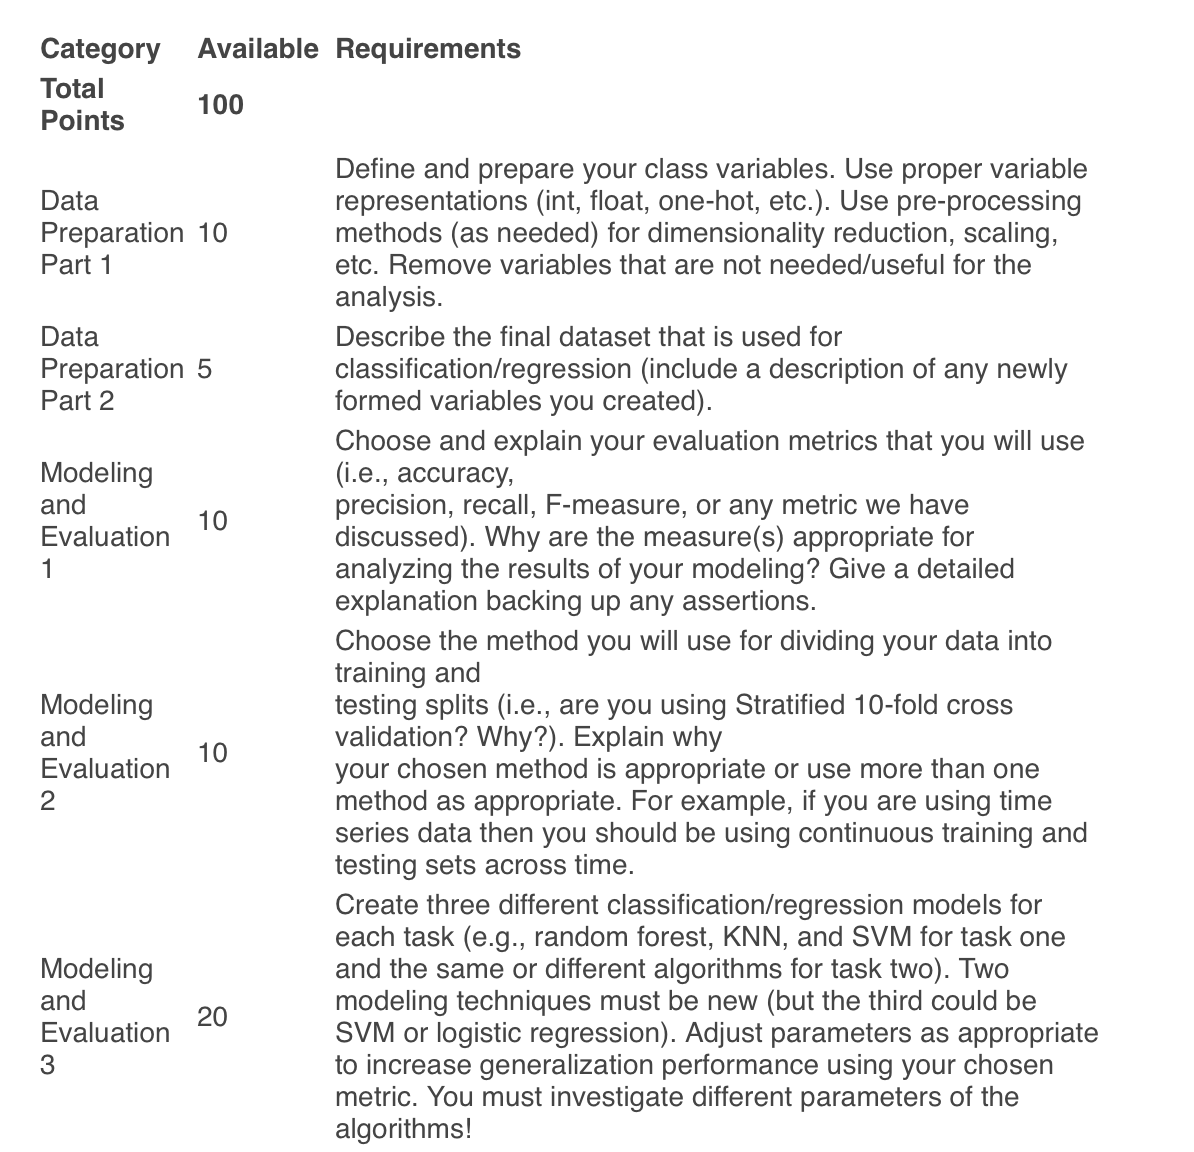

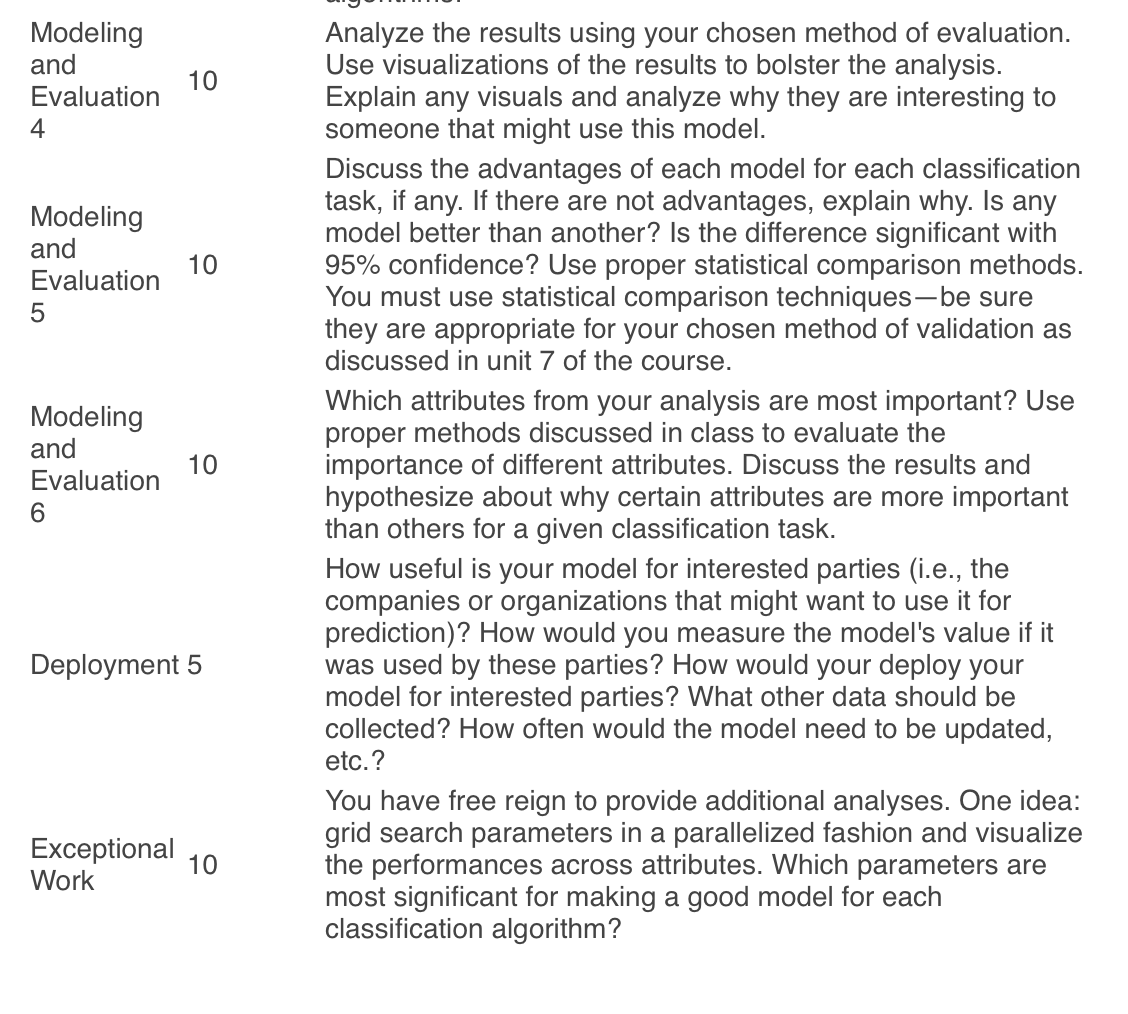

## Introduction

For an introduction to the data, business understanding, and explanation of the the dataset, please see [Lab01](Lab01.ipynb), which contains the exploratory data analysis (EDA) from Lab 01. This notebook will focus on building classification models of the data.

## Import and Process Data

The following code chunks are explained in more detail in [Lab01](Lab01.ipynb).

In [1]:
import pandas as pd

# Choose File
RawBank = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/bank-additional-full.csv"
# RawBank = "data/bank-additional-full.csv"

# Read the CSV file with a semicolon ; separator
bank = pd.read_csv(RawBank, sep=';')

# Get info on the dataset
# print(bank.info())
# bank.describe()

In [2]:
import numpy as np

# let's set those values to NaN, so that Pandas understand they are missing
df = bank.copy() # make a copy of the dataframe
df = df.replace(to_replace = 'unknown', value = np.nan) # replace unknown with NaN (not a number)
df = df.replace(to_replace = 999, value = np.nan) # replace 999 with NaN (not a number)
df = df.replace(to_replace = 'nonexistent', value = np.nan) # replace nonexistent with NaN (not a number)

# print (df.info())
# df.describe() # scroll over to see the values

# From course material "01. Pandas.ibynb"

In [3]:
# Change NA Categoricals to 'unknown'
df['job'] = df['job'].fillna('unknown')
df['marital'] = df['marital'].fillna('unknown')
df['education'] = df['education'].fillna('unknown')

# Change NA Credit history values to 'no'
df['default'] = df['default'].fillna('no')
df['housing'] = df['housing'].fillna('no')
df['loan'] = df['loan'].fillna('no')

# Change NA Previous Outcome to 'not contacted'
df['poutcome'] = df['poutcome'].fillna('not contacted')

# Change NA pdays to the mean
df['pdays'] = df['pdays'].fillna(df['pdays'].mean())

# Change NA Duration to '999'
df['duration'] = df['duration'].fillna(999)

# let's break up the age variable
df['age_range'] = pd.cut(df.age,[0,40,60,1e6],3,labels=['Young','Middle-Age','Old']) # this creates a new variable
# df.age_range.describe()

# print(df.info())

## Data Preparation Part 1

Our class variable or response variable, labeled 'y' in the dataset, is a binary object denoting whether the client has subscribed to a term deposit. It takes on two values, 'y' (indicating 'yes') and 'n' (indicating 'no').

The dataset and processing is explained in more detail in [Lab01](Lab01.ipynb).

Scaling and dimensionality reduction will be handled in a SKL `pipeline` object in the model creation section below.

In [4]:
# Convert all categorical features to numeric using dummy variables
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_range'], drop_first=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

The following code chunk generates an Exploratory Data Analysis widget that can be used to check the quality of our processed dataset. It takes a while to run and can be re-rendered by commenting out the triple quotes.

In [9]:
'''

# You can run this if you want to view the YData Profile Report (EDA Report) for the expanded data.
import pandas as pd
from ydata_profiling import ProfileReport

#Run the Profile Report
profile = ProfileReport(
    df, title="df1.html", explorative=True
    )

#Send the code to the HTML File or notebook
# profile.to_file("df1.html")
profile.to_widgets()
# profile.to_notebook_iframe()

'''

'\n\n# You can run this if you want to view the YData Profile Report (EDA Report) for the expanded data.\nimport pandas as pd\nfrom ydata_profiling import ProfileReport\n\n#Run the Profile Report\nprofile = ProfileReport(\n    df, title="df1.html", explorative=True\n    )\n\n#Send the code to the HTML File or notebook\n# profile.to_file("df1.html")\nprofile.to_widgets()\n# profile.to_notebook_iframe()\n\n'

## Data Preparation Part 2

Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

The final dataset is made up of 53 variables. As seen below, the data types are : float64(7), int64(4), object(1), uint8(42)

We changed the initial variables of Job, Marital Status, Education, Default, Housing, Loan, Month, Day of Week, Poutcome, and Age Range into distinct levels using methods seen in [Lab01](Lab01.ipynb).

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

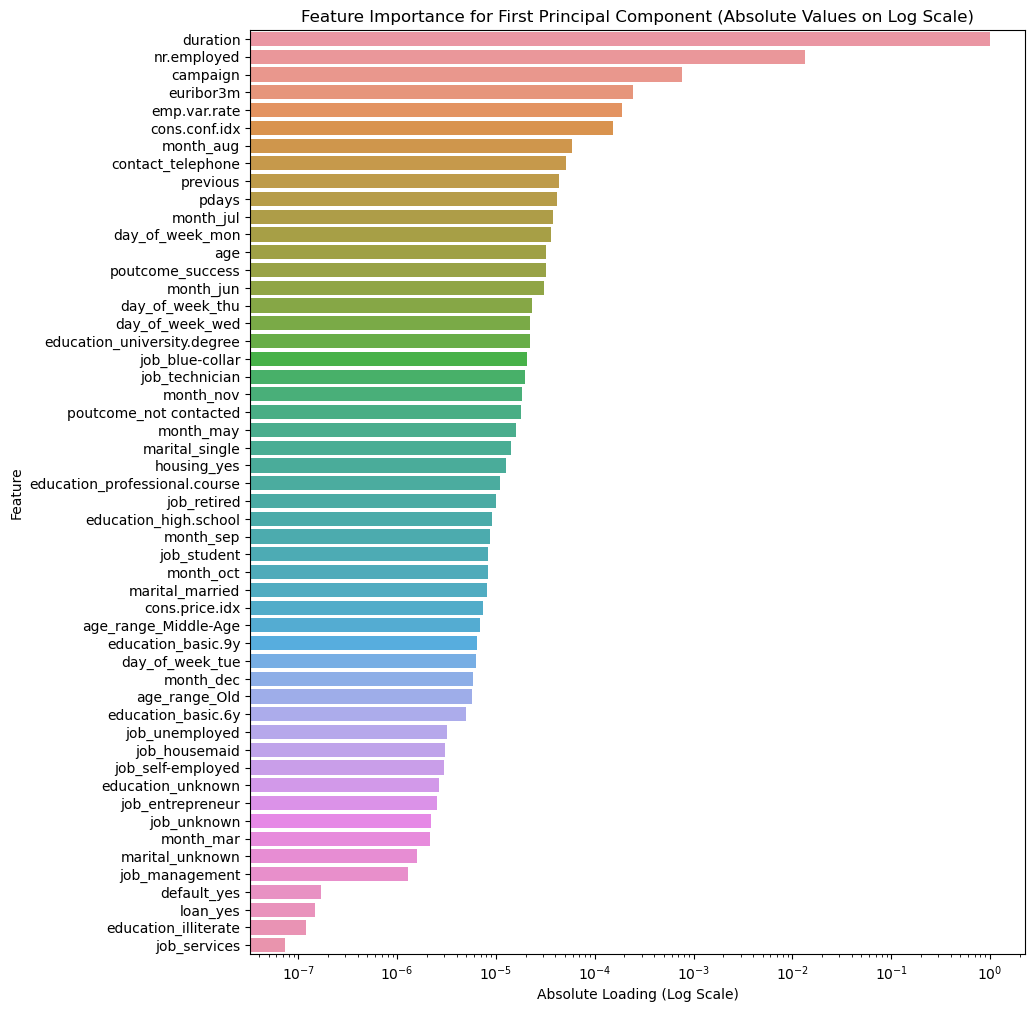

The feature loadings of the first principal component are shown on the figure above. They are plotted as absolute values, so they can be regarded as feature importance. The scale is logarithmic, so the difference in feature importance is much larger than it appears. We can see that 'Duration' is by far the most important feature, followed by 'Employment Number (Portugal)' and 'Campaign'. The economic features are all fairly highly ranked, which suggests they are an important predictor of subscription to a term deposit.

## Modeling and Evaluation 1

ROC - AUC will be used to evaluate the models.

Due to previous work in Lab01.ipynb it was shown that our response variable, whether a customer will subscribe to a term deposit, was highly unbalanced with only 11% of the variable data being 'yes' so for the metric we will choose ROC-AUC. The common metric accuracy would not be good for this model due to it only being able to assess the correct number of true predictions in the samples from the dataset but fails to take into account the false positives. 

The Area Under the Curve is great for classification models and takes into account the relationship between the true positive rate and the false positive rate. It's value is contained in the range of 0.5 and 1 being that if the models auc is 0.5 it predicts no better than a flip of a coin at random or 1 being that it is the perfect classifier. In our case, the accuracy of a model that only guesses the majority class would approach 90%, but the true positive rate would be 0%. The ROC-AUC allows us to evaluate how the model performs on both the minority and majority classes.

Because we are primarily concerned with the minority class, we could also use the F1 score, balanced accuracy, precision-recall curve, or the Matthews correlation coefficient (MCC). We have chosen the ROC-AUC because it is easy to interpret and the others were not covered in the course.

## Modeling and Evaluation 2

Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

First, we will change the data into a format that Scikit-Learn can use. We will also split the data into training and validation sets.

The code in this section is adopted from the course material in the notebook '04. Logits and SVM.ipynb'.

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

# Consider deleting duration for practicality
if 'duration' in df: del df['duration']

# we want to predict the X and y data as follows:
X = df.drop(columns=['y']).values
y = df['y'].values
    
# Split into training and test sets
X_train_holdout, X_test_holdout, y_train_holdout, y_test_holdout = train_test_split(
    X, y, test_size=0.2, random_state=137, stratify=y)


The 'holdout' splits will be used to evaluate the final model on unseen data. We will additionally use cross-validation to tune the hyperparameters of the models.

Next we will define the parts of the pipeline that will be used to transform the data and fit the models. We will use a StandardScaler to scale the data, and experiment with using PCA to reduce the dimensionality of the data.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Resampling related libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnPipeline

resample = SMOTE()

# Define the model as a placeholder to use in the pipeline
model = LogisticRegression(penalty='l2',
                           C=1.0,
                           class_weight=None,
                           solver='liblinear',
                           random_state=137,
                           max_iter=150)

# Define the pipeline
pipe = imblearnPipeline([
    ('resample', resample),
    ('scaler', StandardScaler()),
    ('classifier', model)
])
# Use pipe.set_params(classifier=model) to change the model

# Define the cross validation method on training holdout
skf = StratifiedKFold(n_splits=5, random_state=137, shuffle=True)

We have chosen to use a stratified 5-fold cross validation to evaluate our models. Stratified is necessary because it preserves the proportion of samples of each class in each fold. Because the dataset is so imbalanced, non-stratified cross validation could result in some folds having no samples of the minority class, which would make the models impossible to evaluate or give misleading results.

We have chosen 5-folds because of the balance between bias and computational efficiency. Larger folds (smaller evaluation sets) more closely approximate the training data in size and thus will have lower bias. However, with our unbalanced dataset, this could cause representation problems with the minority class. This configuration is also more computationally demanding. Five folds is considered to be a good balance between these two factors.

Additionally, we will used the Imbalanced Learn Pipeline module to implement minority class oversampling within the cross validation loop. This will help to address the class imbalance problem. This module doesn't allow the oversampled synthetic data to leak into the validation phase because the resampling only occurs within the training portion of each fold during the cross-validation process. Synthetic Minority-class Oversampling Technique (SMOTE) is chosen because it is a popular and effective oversampling method.

## Modeling and Evaluation 3


Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

## Modeling and Evaluation 4

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

## Modeling and Evaluation 5

Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

## Modeling and Evaluation 6

Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Deployment

How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Exceptional Work

Change this. Possibly more hyperparameters.

You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

## References

@article{Moro2014ADA,
  title={A data-driven approach to predict the success of bank telemarketing},
  author={S{\'e}rgio Moro and P. Cortez and Paulo Rita},
  journal={Decis. Support Syst.},
  year={2014},
  volume={62},
  pages={22-31},
  url={https://api.semanticscholar.org/CorpusID:14181100}
}



## Leaving Chunks in for Reference
## Following sections are from Mini-lab
In this section, we will create Logistic Regression and Support Vector Machine (SVM) models to classify whether a customer will subscribe to a term deposit. We will split the data into training and validation sets using an 80/20 split. ROC - AUC will be used to evaluate the models.

Due to previous work in Lab01.ipynb it was shown that our response variable, whether a customer will subscribe to a term deposit, was highly unbalanced with only 11% of the variable data being 'yes' so for the metric we will choose ROC-AUC. The common metric accuracy would not be good for this model due to it only being able to assess the correct number of true predictions in the samples from the dataset but fails to take into account the false positives. 

The Area Under the Curve is great for classification models and understands the relationship between the true positive rate and the false positive rate. It's value is contained in the range of 0.5 and 1 being that if the models auc is 0.5 it predicts no better than a flip of a coin at random or 1 being that it is the perfect classifier. 

The code in this section is adopted from the course material in the notebook '04. Logits and SVM.ipynb'.

### Logistic Regression:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Define the model
lr_model = LogisticRegression(penalty='l2',
                           C=1.0,
                           class_weight=None,
                           solver='liblinear',
                           random_state=137,
                           max_iter=150)

# Define the pipeline
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lr_model)
])

# Define the cross validation method on training holdout
skf = StratifiedKFold(n_splits=5, random_state=137, shuffle=True)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics as mt

# Lists to store metrics for each fold
rocauc_lr = []

for train_index, val_index in skf.split(X_train_holdout, y_train_holdout):
    # Splitting the data
    X_train, X_val = X_train_holdout[train_index], X_train_holdout[val_index]
    y_train, y_val = y_train_holdout[train_index], y_train_holdout[val_index]
    
    # Train the model on the training data
    lr_pipe.fit(X_train, y_train)
    
    # Predict on the test data
    # y_pred = lr_pipe.predict(X_val) # Incorrect
    y_pred_prob = lr_pipe.predict_proba(X_val)[:, 1] # Need to use probability estimates here

    # Calculate ROC-AUC
    ra = roc_auc_score(y_val, y_pred_prob)
    rocauc_lr.append(ra)
    
    # Optionally, print the ROC-AUC for each fold
    print(f"ROC-AUC for fold: {len(rocauc_lr)} is {ra:.4f}")

# Calculate mean and std deviation of the ROC-AUC's
mean_ra_lr = np.mean(rocauc_lr)
std_ra_lr = np.std(rocauc_lr)

print(f"\nOverall ROC-AUC: {mean_ra_lr:.4f} (+/- {std_ra_lr:.4f})")


ROC-AUC for fold: 1 is 0.8019
ROC-AUC for fold: 2 is 0.7869
ROC-AUC for fold: 3 is 0.7796
ROC-AUC for fold: 4 is 0.7929
ROC-AUC for fold: 5 is 0.8078

Overall ROC-AUC: 0.7938 (+/- 0.0101)


In [ ]:
# Implement the same thing a different way for practice
from sklearn.model_selection import cross_val_score

rocauc_lr2 = cross_val_score(estimator=lr_pipe,
                                X=X_train_holdout,
                                y=y_train_holdout,
                                cv=skf,
                                scoring="roc_auc",
                                n_jobs=-1)
print(rocauc_lr2)

# Calculate mean and std deviation of the accuracies
mean_ra_lr2 = np.mean(rocauc_lr2)
std_ra_lr2 = np.std(rocauc_lr2)

print(f"\nOverall ROC-AUC: {mean_ra_lr2:.4f} (+/- {std_ra_lr2:.4f})")
# Same results and faster

[0.80186467 0.78693236 0.77961941 0.79288789 0.80776961]

Overall ROC-AUC: 0.7938 (+/- 0.0101)


The AUC of each fold is approximately 79%. This is about 14% lower than when 'duration' is included. By removing it, we have a more practical model with only a small loss in predictive power. This small loss in predictive power is a good trade off to have a model that is useful in the real world.

Next, we will evaluate the final model on the holdout set.

In [ ]:
#fitting the model
lr_pipe.fit(X_train_holdout, y_train_holdout)

#prediction on the test set
final_y_pred_prob = lr_pipe.predict_proba(X_test_holdout)[:,1    ]

#calculating the ROC-AUC performance
final_performance = roc_auc_score(y_test_holdout, final_y_pred_prob)
print(f"Final Model Performance on Holdout Set: {final_performance:.4f}")


Final Model Performance on Holdout Set: 0.7785


The Logistic Regression model achieves an accuracy of 77.85% on the holdout set. 

Before moving on, we will use a grid search with the cross validation object to tune the hyperparameters of the Logistic Regression model. The parameters in the grid search are a rough estimate, and further tuning could be done on a narrower range once the best parameters are found.

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid_logistic = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(lr_pipe, param_grid_logistic,
                           cv=skf, n_jobs=-1, error_score=np.nan,
                           scoring='roc_auc')
grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score (ROC-AUC): ", grid_search.best_score_)


c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antho\AppD

Best parameters:  {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score (ROC-AUC):  0.7911546135814282


The best parameters are C=0.1 and penalty='l1' using the 'liblinear' solver. The best ROC-AUC 79.1%, which is comparable to the baseline model without tuning. Many combinations of parameters wither failed to converge or failed due to mismatch of the solver and penalty, but the grid search can be forced to run by setting `error_score=np.nan`.

### Support Vector Machine:

We will implement our Support Vector machine which will be done in similar fashion as the Logistic Regression in the section above. One model will be made using a pipeline and the other with the cross_val_score function. We will also implement the svm later on using stochastic gradient descent.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Define the model
svm_model = SVC(C=1.0,
            kernel='rbf',
            gamma='scale',
            class_weight=None,
            random_state=137)

# Define the pipeline
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', svm_model)
])

# Define the cross validation method on training holdout
skf = StratifiedKFold(n_splits=5, random_state=137, shuffle=True)

Here we define a pipeline for the SVM model. We will use a StandardScaler to scale the data, and the 'rbf' kernel. 

In [ ]:
# Implement CV using the shorter method with much faster processing speed
from sklearn.model_selection import cross_val_score

rocauc_svm = cross_val_score(estimator=svm_pipe,
                                X=X_train_holdout,
                                y=y_train_holdout,
                                scoring = "roc_auc",
                                cv=skf,
                                n_jobs=-1)
print(rocauc_svm)

# Calculate mean and std deviation of the accuracies
mean_ra_svm = np.mean(rocauc_svm)
std_ra_svm = np.std(rocauc_svm)

print(f"\nOverall ROC-AUC: {mean_ra_svm:.4f} (+/- {std_ra_svm:.4f})")

[0.71711941 0.72241794 0.71886281 0.71558283 0.72143967]

Overall ROC-AUC: 0.7191 (+/- 0.0026)


The AUC of each fold is approximately 71%. This is about 8% lower than the logistic regression model

In [ ]:
#fitting the model
svm_pipe.fit(X_train_holdout, y_train_holdout)

#prediction on the test set
final_y_pred_prob = svm_pipe.decision_function(X_test_holdout)#[:,1] # Using decision_function instead of predict_proba

#calculating the ROC-AUC performance
final_performance = roc_auc_score(y_test_holdout, final_y_pred_prob)
print(f"Final Model Performance on Holdout Set: {final_performance:.4f}")


Final Model Performance on Holdout Set: 0.7030


The SVM model achieves an AUC of 70.3% on the holdout set. This is approximately 8% lower than the Logistic Regression model as predicted by the cross validation scores.

Before moving on, we will use a grid search with the cross validation object to tune the hyperparameters of the SVM model. The parameters in the grid search are a rough estimate, and further tuning could be done on a narrower range once the best parameters are found.

In [ ]:
# Don't run this. 51m to run on my machine

# from sklearn.model_selection import GridSearchCV

# # Define hyperparameter space
# param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
#               'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

# # Use GridSearchCV
# grid_search = GridSearchCV(svm_pipe, param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
# grid_search.fit(X, y)

# print("Best parameters: ", grid_search.best_params_)
# print("Best cross-validation score: ", grid_search.best_score_)

The grid search yields an optimal `C` of `1.0`, and `gamma` of `0.01`. The accuracy of the model with these parameters is 89.9%, which is equivalent to the model using the default parameters. The grid search was not evaluated using ROC-AUC due to the negligible accuracy improvement. It takes a very long time.

### SVM with SGD:

Next, we will implement a SVM model using Stochastic Gradient Descent. This should improve the relatively long training times of the previous model. We will compare the performance of the two models.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Define the model
svm_sgd_model = SGDClassifier(alpha=0.1,
                              fit_intercept=True,
                              l1_ratio=0.0,
                              learning_rate='optimal',
                              loss='hinge',
                              n_iter_no_change=5,
                              n_jobs=-1,
                              penalty='l2',
                              random_state=137)


# Define the pipeline
svm_sgd_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', svm_sgd_model)
])

# Define the cross validation method on training holdout
skf = StratifiedKFold(n_splits=5, random_state=137, shuffle=True)

Here we define a pipeline using SGD with a linear Support Vector Classifier. We will again use a StandardScaler to scale the data.

In [ ]:
# Implement CV using the shorter method
from sklearn.model_selection import cross_val_score

rocauc_svm_sgd = cross_val_score(estimator=svm_sgd_pipe,
                                X=X_train_holdout,
                                y=y_train_holdout,
                                cv=skf,
                                scoring = "roc_auc",
                                n_jobs=-1)
print(rocauc_svm_sgd)

# Calculate mean and std deviation of the accuracies
mean_ra_sgd = np.mean(rocauc_svm_sgd)
std_ra_sgd = np.std(rocauc_svm_sgd)

print(f"\nOverall ROC-AUC: {mean_ra_sgd:.4f} (+/- {std_ra_sgd:.4f})")

[0.74205686 0.72319043 0.72956705 0.72485194 0.78402482]

Overall ROC-AUC: 0.7407 (+/- 0.0226)


The Stochastic Gradient Descent classifier has a ROC-AUC of approximately 74% on the cross validation set. It has a slightly higher variance between folds than the other models.

In [ ]:
#fitting the model
svm_sgd_pipe.fit(X_train_holdout, y_train_holdout)

#prediction on the test set
final_y_pred_prob = svm_sgd_pipe.decision_function(X_test_holdout)#[:,1] # Using decision_function instead of predict_proba

#calculating the ROC-AUC performance
final_performance = roc_auc_score(y_test_holdout, final_y_pred_prob)
print(f"Final Model Performance on Holdout Set: {final_performance:.4f}")


Final Model Performance on Holdout Set: 0.7151


The SVM model using gradient descent achieves an AUC of 71.5% on the holdout set. This is roughly the same the previous SVM model with much less computation time. It is interesting to note that the difference between the validation set and cross validation scores is higher with this model. This suggests that SGD may be more prone to overfitting.

However there is a trade off that happens because of this SGD does iterative steps approximating the gradient and when it finds the minima its only a local minima of the loss function. There might be many local minima that are within the loss function and the one chosen due to the step size may not be the global minima. Another thing, the Stochastic GD takes a lot more steps in its epoch time than a normal gradient descent making it more computationally expensive.

As with the previous models, we will use a grid search to tune the hyperparameters of the model.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter space
param_grid = {'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
              'classifier__learning_rate': ['constant', 'optimal', 'invscaling'],
              'classifier__eta0': [0.001, 0.01, 0.1, 1]}

# Use GridSearchCV
grid_search = GridSearchCV(svm_sgd_pipe, param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters:  {'classifier__alpha': 0.01, 'classifier__eta0': 0.01, 'classifier__learning_rate': 'invscaling'}
Best cross-validation score:  0.7232288266892251


Like the previous models, the hyperparameters we have chosen yield similar results to the default parameters. By choosing a more narrow range of parameters, we could possibly improve the performance of the model. However, this finding increases our confidence in SKL's default parameters.